In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats

pd.options.mode.chained_assignment = None

In [2]:
# Specify the path to your data in Google Drive or locally
filePath = "../data/complete_COVID_SAMPLES.tsv" 

df = pd.read_table(filePath, low_memory=False, engine="c")

optional_fields = ['hospitalized']

In [3]:
# Select the columns that are listed above
df = df[['sample', 'templates', 'amino_acid', 'rearrangement', 'v_resolved', 'd_resolved','j_resolved','hospitalized']]

# Rename the columns 
df.columns = ['sample', '#count' , 'cdr3aa' , 'cdr3nt' , 'v' , 'd' , 'j' , 'hospitalized']

# Remove "_TCRB" part from the sample name
df['sample'] = df['sample'].map(lambda x: x.rstrip('_TCRB'))

# Create a dataframe with reads count for each sample
df_reads = df.groupby(['sample', 'hospitalized']).agg({'#count': 'sum'}).reset_index().rename(columns={'#count': "count"})

# Calculate clonotype frequency
df = pd.merge(df, df_reads, how='outer', on=['sample','hospitalized']).fillna(0)
df['freq'] = df['#count'] / (df['count'] * 1.0)
df.fillna(0, inplace=True)

# Create a dataframe with clonotype count for each sample
df_diversity = df.groupby(['sample', 'hospitalized'], sort=False).size().reset_index(name='clonotype_count')

# Add clonotype count of each sample as a column to create a new dataframe
df = pd.merge(df, df_diversity, on=['sample', 'hospitalized'])

df

,sample,#count,cdr3aa,cdr3nt,v,d,j,hospitalized,count,freq,clonotype_count
0,6232BW,3636,CASSLGLAGPGFF,ACGATCCAGCGCACAGAGCAGGAGGACTCGGCCGTGTATCTCTGTG...,TCRBV07-02,TCRBD02-01*02,TCRBJ02-01*01,True,439782,0.008268,218977
1,6232BW,3037,CASRVGSSYNEQFF,ATCCAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCA...,TCRBV12,TCRBD02-01*02,TCRBJ02-01*01,True,439782,0.006906,218977
2,6232BW,2293,CASNPYRVNTGELFF,GAGTCGCCCAGCCCCAACCAGACCTCTCTGTACTTCTGTGCCAGCA...,TCRBV27-01*01,TCRBD02-01*02,TCRBJ02-02*01,True,439782,0.005214,218977
3,6232BW,1960,CASSALRSSYNEQFF,CAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCAGCT...,TCRBV12,unknown,TCRBJ02-01*01,True,439782,0.004457,218977
4,6232BW,1896,CASSFEDEGGETQYF,AACGCCTTGTTGCTGGGGGACTCGGCCCTCTATCTCTGTGCCAGCA...,TCRBV05-06*01,unknown,TCRBJ02-05*01,True,439782,0.004311,218977
...,...,...,...,...,...,...,...,...,...,...,...
15061643,1566265BW,1,CSVEDLRGGYTF,CTGACTGTGAGCAACATGAGCCCTGAAGACAGCAGCATATATCTCT...,TCRBV29-01,unknown,TCRBJ01-02*01,False,758231,0.000001,453526
15061644,1566265BW,1,CASGRRGDYGYTF,AAGATCCAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTG...,TCRBV12-03/12-04*01,unknown,TCRBJ01-02*01,False,758231,0.000001,453526
15061645,1566265BW,1,CASSWTGNSPLHF,AAGATCCAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTG...,TCRBV12-03/12-04*01,TCRBD02-01,TCRBJ01-06*02,False,758231,0.000001,453526
15061646,1566265BW,1,CASSLDWTEYYEQYF,CAGCCTGCAAAGCTTGAGGACTCGGCCGTGTATCTCTGTGCCAGCA...,TCRBV11-02*01,TCRBD01-01*01,TCRBJ02-07*01,False,758231,0.000001,453526


Clonal proportion

In [4]:
# Create an empty dataframe for storing results
df_clonal_portion = pd.DataFrame()

# Create a list of the sample names
samples = set(df['sample'])


for sample in samples:

    # Store the rows related to the sample 
    df_temp = df.loc[df['sample'] == sample]

    # Sort the sample clonotypes by frequency in descending order
    df_temp = df_temp.sort_values(by='freq', ascending=False)

    # Create a column to store the order
    df_temp['clonotype_number'] = np.arange(df_temp.shape[0])+1

    # Compute and store the cumulative sum of the frequencies
    df_temp['accum_freq'] = df_temp['freq'].cumsum()

    # Filter out accumulated frequencies smaller than 10% (10% can be adjusted by the user)
    df_temp = df_temp.loc[(df_temp['accum_freq']>=0) & (df_temp['accum_freq']<=0.1)]

    # Select the smallest accumulated frequency record and stores in the result dataframe
    df_temp = df_temp.sort_values(by='accum_freq', ascending=False)
    df_temp = df_temp.head(1)  
    df_clonal_portion = pd.concat([df_clonal_portion, df_temp],sort=True)

    # Show the results 
    df_clonal_portion = df_clonal_portion[['sample','hospitalized','clonotype_number']]

df_clonal_portion.columns = ['sample', 'hospitalized', 'clonality_portion']

## FigureS2a - violin plot

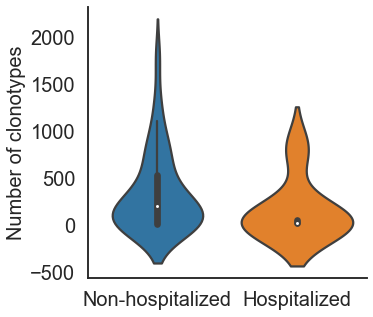

In [5]:
attribute = "hospitalized"

sns.set_style("white") 
sns.set_context("talk")

ax = plt.subplots(figsize=(5,5))

ax = sns.violinplot(x=attribute, y='clonality_portion', data=df_clonal_portion)

ax.set(xlabel=None)
ax.set_ylabel('Number of clonotypes', fontsize=20)
xlabels = ['Non-hospitalized','Hospitalized']
ax.set_xticklabels(xlabels)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
sns.despine()


plt.savefig("../figures/supplementary/figureS2a.pdf",bbox_inches="tight")
plt.savefig("../figures/supplementary/figureS2a.png",bbox_inches="tight")

plt.show()

## FigureS2b - strip plot

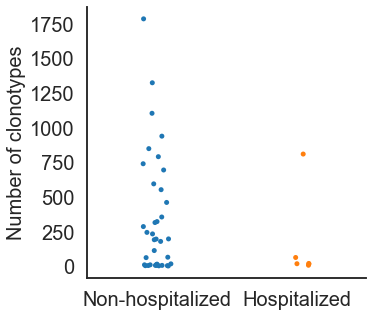

In [6]:
attribute = "hospitalized"

sns.set_style("white") 
sns.set_context("talk")

ax = plt.subplots(figsize=(5,5))

ax = sns.stripplot(x=attribute, y='clonality_portion', data=df_clonal_portion)

ax.set(xlabel=None)
ax.set_ylabel('Number of clonotypes', fontsize=20)
xlabels = ['Non-hospitalized','Hospitalized']
ax.set_xticklabels(xlabels)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
sns.despine()

plt.savefig("../figures/supplementary/figureS2b.pdf",bbox_inches="tight")
plt.savefig("../figures/supplementary/figureS2b.png",bbox_inches="tight")

plt.show()

## FigureS2c - swarm plot

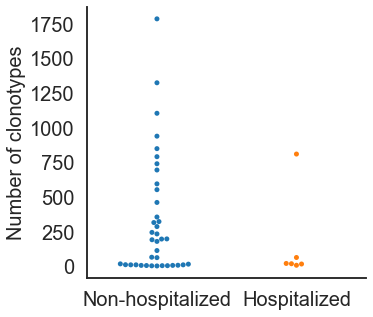

In [7]:
attribute = "hospitalized"

sns.set_style("white") 
sns.set_context("talk")

ax = plt.subplots(figsize=(5,5))

ax = sns.swarmplot(x=attribute, y='clonality_portion', data=df_clonal_portion)

ax.set(xlabel=None)
ax.set_ylabel('Number of clonotypes', fontsize=20)
xlabels = ['Non-hospitalized','Hospitalized']
ax.set_xticklabels(xlabels)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
sns.despine()

plt.savefig("../figures/supplementary/figureS2c.pdf",bbox_inches="tight")
plt.savefig("../figures/supplementary/figureS2c.png",bbox_inches="tight")

plt.show()

## FigureS2d - box plot

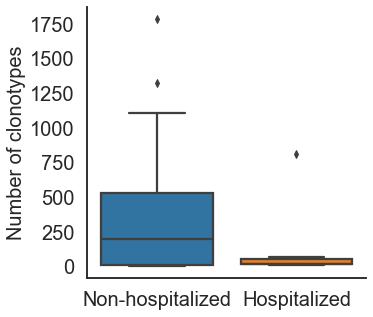

In [8]:
attribute = "hospitalized"

sns.set_style("white") 
sns.set_context("talk")

ax = plt.subplots(figsize=(5,5))

ax = sns.boxplot(x=attribute, y='clonality_portion', data=df_clonal_portion)

ax.set(xlabel=None)
ax.set_ylabel('Number of clonotypes', fontsize=20)
xlabels = ['Non-hospitalized','Hospitalized']
ax.set_xticklabels(xlabels)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
sns.despine()

plt.savefig("../figures/supplementary/figureS2d.pdf",bbox_inches="tight")
plt.savefig("../figures/supplementary/figureS2d.png",bbox_inches="tight")

plt.show()

## FigureS2e - boxen plot

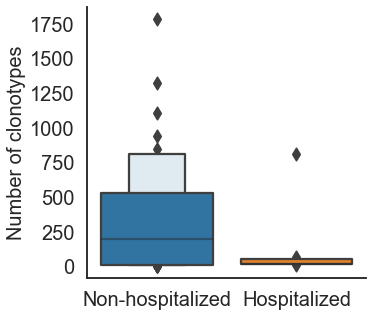

In [9]:
attribute = "hospitalized"

sns.set_style("white") 
sns.set_context("talk")

ax = plt.subplots(figsize=(5,5))

ax = sns.boxenplot(x=attribute, y='clonality_portion', data=df_clonal_portion)

ax.set(xlabel=None)
ax.set_ylabel('Number of clonotypes', fontsize=20)
xlabels = ['Non-hospitalized','Hospitalized']
ax.set_xticklabels(xlabels)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
sns.despine()

plt.savefig("../figures/supplementary/figureS2e.pdf",bbox_inches="tight")
plt.savefig("../figures/supplementary/figureS2e.png",bbox_inches="tight")

plt.show()

## FigureS2f - point plot

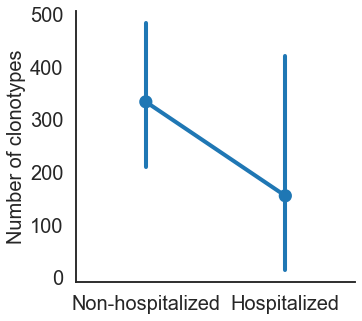

In [10]:
attribute = "hospitalized"

sns.set_style("white") 
sns.set_context("talk")

ax = plt.subplots(figsize=(5,5))

ax = sns.pointplot(x=attribute, y='clonality_portion', data=df_clonal_portion)

ax.set(xlabel=None)
ax.set_ylabel('Number of clonotypes', fontsize=20)
xlabels = ['Non-hospitalized','Hospitalized']
ax.set_xticklabels(xlabels)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
sns.despine()

plt.savefig("../figures/supplementary/figureS2f.pdf",bbox_inches="tight")
plt.savefig("../figures/supplementary/figureS2f.png",bbox_inches="tight")

plt.show()

## FigureS2g - bar plot

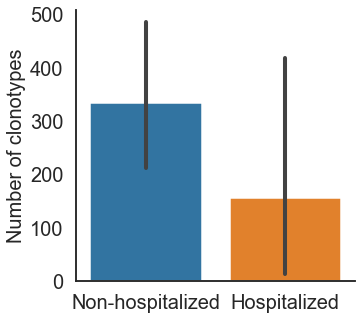

In [11]:
attribute = "hospitalized"

sns.set_style("white") 
sns.set_context("talk")

ax = plt.subplots(figsize=(5,5))

ax = sns.barplot(x=attribute, y='clonality_portion', data=df_clonal_portion)

ax.set(xlabel=None)
ax.set_ylabel('Number of clonotypes', fontsize=20)
xlabels = ['Non-hospitalized','Hospitalized']
ax.set_xticklabels(xlabels)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
sns.despine()

plt.savefig("../figures/supplementary/figureS2g.pdf",bbox_inches="tight")
plt.savefig("../figures/supplementary/figureS2g.png",bbox_inches="tight")

plt.show()